In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import time
import numpy as np
import xarray as xr
import time
import numpy as np
import cartopy.crs as ccrs
import cartopy as cart
import xclim as xc
import os
from memory_profiler import profile

from matplotlib.colors import BoundaryNorm
import matplotlib.ticker as mticker
import matplotlib.colors as mplcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean as cmo

import matplotlib.gridspec as gridspec
# own functions
import Plot.plotfunctions as plotfunc
import Calculation.humiditycalculation as humidcalc
import Calculation.trend_func as trends
import Calculation.save_detrend_deseason as sdd
import Calculation.heat_wave_indetification as hwi
import Calculation.mask_creation as mc
homefolder = '/home/nniebaum/data_nils'
datafolder = '/data/user/nniebaum'
plotfolder = '/home/nniebaum/bachlor-thesis-code/Plots/'
areafolder = plotfolder + "Area/"

subfigure_label = ['a) ','b) ','c) ','d) ','e) ','f) ','g) ','h) ', 'i)', 'j)']
idx_subfigure_label = 0

plt.rcParams.update(plotfunc.rcParams_area)
projection = ccrs.EckertV(central_longitude=12.5)

/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/xclim/indices/_multivariate.py:18: UserWarning: xclim.indices.generic has been refactored in xclim v0.21.0 and has moved several functions to 'xclim.indices.stats'. The affected functions are as follows: `fit`, `parametric_quantile`, `fa`, `frequency_analysis`, `get_dist`, `get_lm3_dist`, `_fit_start`, `_lm3_dist_map`. They have been made available here for your convenience. This functionality will change in xclim v0.22.0. Please update your scripts accordingly.
  from .generic import select_resample_op


**Open daily max dataset**

In [2]:
data= xr.open_dataset(datafolder + '/New2_europe_full_daymax_masks_population_1900-01-01_2010-12-31.nc')


duration = data.heatwave_mask_ydrunpctl_98_referenceperiod.attrs['duration']
threshold = data.heatwave_mask_ydrunpctl_98_referenceperiod.attrs['threshold']
quantile = data.heatwave_mask_ydrunpctl_98_referenceperiod.attrs['quantile']

**Examples of strong heat waves**

/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


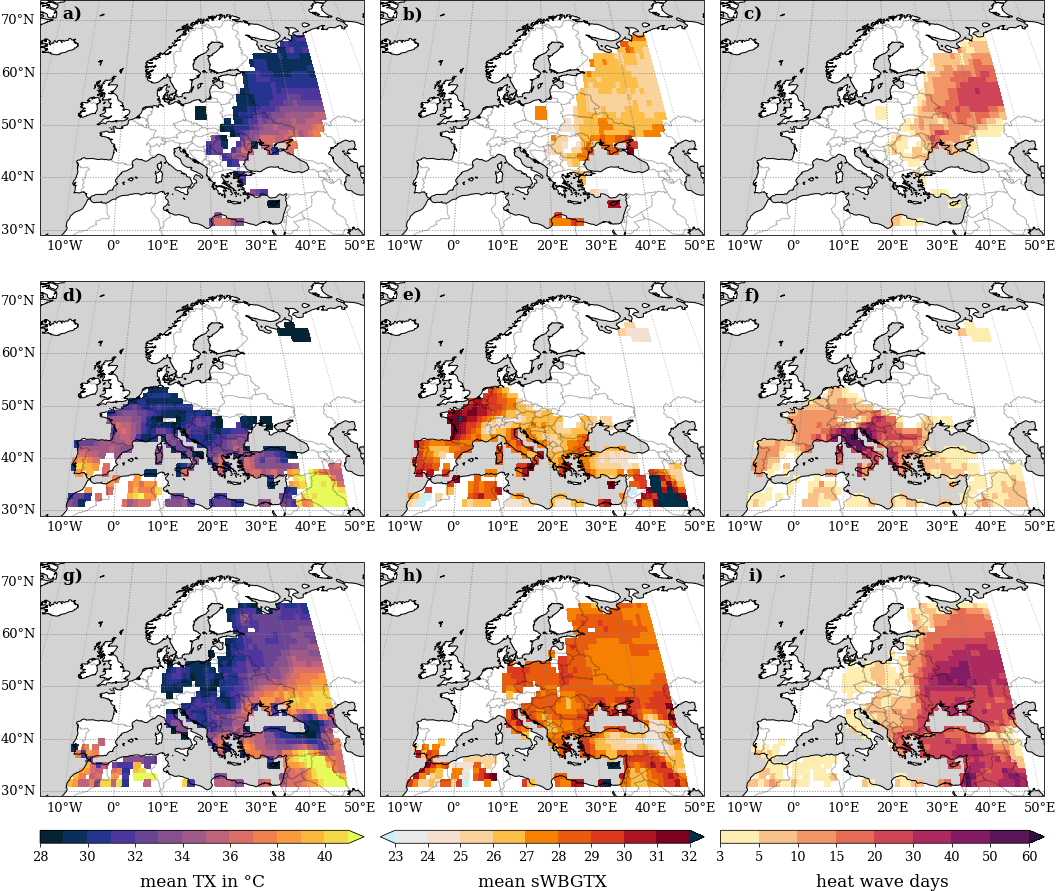

In [3]:
figure_title = "Strong heat waves \nheat wave definition: \n {:.0f} days duration, {:.0f}°C daily max. temperature threshold, {:.0f}th percentile of temperature".format(duration, threshold, quantile*100)
fig = plt.figure(figsize = (18,16))
gs = gridspec.GridSpec(31, 3, hspace = 0.01, wspace = 0.05)
# fig.suptitle(figure_title, y=0.94)
# hex_list = ['#ffffff', '#f4f4f9', '#ffff3f', '#f9dcc4', '#fcbf49', '#f77f00', '#d62828', '#6a040f', '#003049']
# cmap_hwmid = plotfunc.get_continuous_cmap(hex_list, float_list=[0, 0.1, 0.25,0.4, 0.5, 0.75, 0.85, 0.99, 1])
hex_list = ['#caf0f8', '#eaeaea', '#f9dcc4', '#fcbf49', '#f77f00', '#d62828', '#6a040f', '#720026', '#003049']
cmap_hwmid = plotfunc.get_continuous_cmap(hex_list, float_list=[0, 0.1, 0.25,0.4, 0.5, 0.75, 0.85, 0.99, 1])
slices = [slice("1972-01","1972-12"), slice("2003-01","2003-12"), slice("2010-01","2010-12")]



idx = 0
idx_subfigure_label = 0
for timeslice in slices:

    # plot temperature
        ax0 = fig.add_subplot(gs[idx*10:(idx+1)*10, 0],\
            projection=projection)
        ax0.set_extent([-17,51,29,73])
        plot_data = data.t2m.where(data.heatwave_mask_ydrunpctl_98_referenceperiod).sel(time = timeslice).mean('time')
        plot_data = plot_data.where(data.mask_land)
        pm0, ct0 = plotfunc.area_plot(data= plot_data, ax = ax0, \
                    levels = np.arange(28,42,1), \
                    cmap = 'cmo.thermal',
                    colorbar_kwargs = dict(extend = 'max', add_colorbar = False),
                    axes_title = subfigure_label[idx_subfigure_label])
        idx_subfigure_label += 1
    # plot sWBGT
        ax1 = fig.add_subplot(gs[idx*10:(idx+1)*10, 1],\
            projection=projection)
        ax1.set_extent([-17,51,29,73])
        plot_data = data.swbgt.where(data.heatwave_mask_ydrunpctl_98_referenceperiod).sel(time = timeslice).mean('time')
        plot_data = plot_data.where(data.mask_land)
        pm1, ct1 = plotfunc.area_plot(data= plot_data, ax = ax1, \
                    levels = np.arange(23,33,1), \
                    cmap = plotfunc.thermal_low_extend,
                    colorbar_kwargs = dict(extend = 'both', add_colorbar = False),
                    gridline_kwargs = dict(left_labels = False),
                    axes_title = subfigure_label[idx_subfigure_label])
        idx_subfigure_label += 1
    # plot heat wave days
        ax2 = fig.add_subplot(gs[idx*10:(idx+1)*10, 2],\
            projection=projection)
        ax2.set_extent([-17,51,29,73])
        plot_data = data.heatwave_mask_ydrunpctl_98_referenceperiod.sel(time = timeslice).sum("time")
        plot_data = plot_data.where(data.mask_land).where(plot_data >= duration)
        pm2, ct2 = plotfunc.area_plot(data= plot_data, ax = ax2, \
            levels = [3,5,10,15,20,30,40,50,60], \
            cmap = 'cmo.matter',
            colorbar_kwargs = dict(extend = 'max', add_colorbar = False),
                    gridline_kwargs = dict(left_labels = False),
            axes_title = subfigure_label[idx_subfigure_label])
#         ax2.set_title(subfigure_label[idx_subfigure_label], backgroundcolor= 'w', zorder = 15) # + "{} to {} heat wave days".format(timeslice.start, timeslice.stop))
        idx_subfigure_label += 1
        idx += 1

def create_cbar_axes(ax):
    pos = ax.get_position()
    return fig.add_axes([pos.x0 , pos.y0 - pos.height *0.2, pos.width, pos.width  *0.045], frameon = False, xticks = [], yticks = [])
ax0 = create_cbar_axes(ax0)
ax1 = create_cbar_axes(ax1)
ax2 = create_cbar_axes(ax2)
# ax1 = fig.add_subplot(gs_outer[1,-1], frameon = False, xticks = [], yticks = [])
# ax2 = fig.add_subplot(gs_outer[2,-1], frameon = False, xticks = [], yticks = [])

plotfunc.add_cbar(fig,ax0,mapple_object=pm0, percentage = "120%", divide = False, extend = 'max', orientation = 'horizontal', label = 'mean TX in °C')
plotfunc.add_cbar(fig,ax1,mapple_object=pm1, percentage = "120%", divide = False, extend = 'both', orientation = 'horizontal', label = 'mean sWBGTX')
plotfunc.add_cbar(fig,ax2,mapple_object=pm2, percentage = "120%", divide = False, extend = 'max', orientation = 'horizontal', label = "heat wave days")


# #         dived = False
# ax0 = fig.add_subplot(gs[-1,0], frameon = False, xticks = [], yticks = [])
# ax1 = fig.add_subplot(gs[-1,1], frameon = False, xticks = [], yticks = [])
# ax2 = fig.add_subplot(gs[-1,2], frameon = False, xticks = [], yticks = [])

# plotfunc.add_cbar(fig,ax0,mapple_object=pm0, percentage = "100%", divide = False, extend = 'max', orientation = 'horizontal', label = 'Temperature in °C')
# plotfunc.add_cbar(fig,ax1,mapple_object=pm1, percentage = "100%", divide = False, extend = 'both', orientation = 'horizontal', label = 'sWBGT')
# plotfunc.add_cbar(fig,ax2,mapple_object=pm2, percentage = "100%", divide = False, extend = 'max', orientation = 'horizontal', label = "heat wave days")

fig.savefig(areafolder + 'example_heat_waves_ydrunpctl_98_referenceperiod')

**Plot 30 year periods**

/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


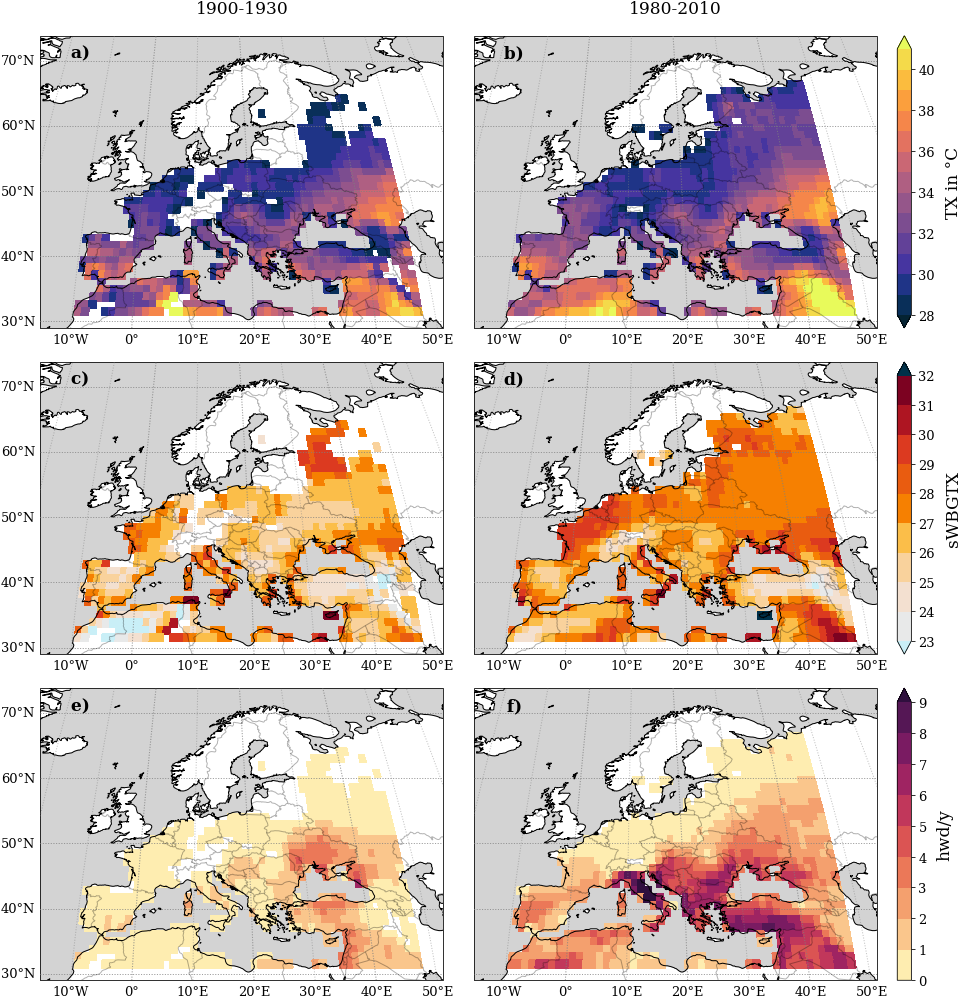

In [4]:
figure_title = "Heat wave definition: \n {:.0f} days duration, {:.0f}°C daily max. temperature threshold, {:.0f}th percentile of temperature".format(duration, threshold, quantile*100)
fig = plt.figure(figsize = (15,18))
idx_subfigure_label = 0
gs = gridspec.GridSpec(nrows = 3, ncols = 2, wspace = 0.075, hspace = 0.0)
# gs_outer = gridspec.GridSpec(nrows = 3, ncols = 2, hspace = 0.3)

# fig.suptitle(figure_title, y=0.94)


timeslice_first = slice("1900","1930")
timeslice_last = slice("1980","2010")
duration = 3
idx = 0

ax0 = fig.add_subplot(gs[:,0])
ax0.axis('off')
ax0.set_title('1900-1930') #, fontsize = 15)

ax0 = fig.add_subplot(gs[:,1])
ax0.axis('off')
ax0.set_title('1980-2010')#\nmean values during heat waves', fontsize = 15)

# ax0 = fig.add_subplot(gs_outer[:,2])
# ax0.axis('off')
# ax0.set_title('Change', fontsize = 15)

idx = 0
idx_title = 0
left_labels = True
for timeslice in [timeslice_first, timeslice_last]:
    
        
        total_years = (int(timeslice.start) - int(timeslice.stop))

# plot temperature
        ax0 = fig.add_subplot(gs[0, idx], projection=projection)
        plot_data = data.t2m.where(data.heatwave_mask_ydrunpctl_98_referenceperiod).sel(time = timeslice).mean('time')
        plot_data = plot_data.where(data.mask_land)
        pm0, ct0 = plotfunc.area_plot(data= plot_data, ax = ax0,             levels = np.arange(28,42,1),             cmap = 'cmo.thermal',
            colorbar_kwargs = dict(add_colorbar = False, extend = 'both'),
                    gridline_kwargs = dict(left_labels = left_labels),
                    axes_title = subfigure_label[idx_subfigure_label])
        idx_subfigure_label += 2
        
        # plot sWBGT
        ax1 = fig.add_subplot(gs[1,idx], projection=projection)
        plot_data = data.swbgt.where(data.heatwave_mask_ydrunpctl_98_referenceperiod).sel(time = timeslice).mean('time')
        plot_data = plot_data.where(data.mask_land)
        pm1, ct1 = plotfunc.area_plot(data= plot_data, ax = ax1,             levels = np.arange(23,33,1),             cmap = plotfunc.thermal_low_extend,
            colorbar_kwargs = dict(add_colorbar = False, extend = 'both'),
                    gridline_kwargs = dict(left_labels = left_labels),
                    axes_title = subfigure_label[idx_subfigure_label])
        idx_subfigure_label += 2
        
# plot heat wave days
        ax2 = fig.add_subplot(gs[2,idx], projection=projection)
        plot_data = data.heatwave_mask_ydrunpctl_98_referenceperiod.sel(time = timeslice).sum("time") / 31
        plot_data = plot_data.where(data.mask_land).where(plot_data != 0)
        pm2, ct2 = plotfunc.area_plot(data= plot_data, ax = ax2,
            levels = np.arange(0,10,1), 
            cmap = 'cmo.matter',
            colorbar_kwargs = dict(add_colorbar = False, extend = 'max'),
                    gridline_kwargs = dict(left_labels = left_labels),
                    axes_title = subfigure_label[idx_subfigure_label])
        idx_subfigure_label += 2
        
        idx += 1
        idx_subfigure_label -= 5
        left_labels = False


 #         dived = False
def create_cbar_axes(ax):
    pos = ax.get_position()
    return fig.add_axes([pos.x0 + pos.width *1.05, pos.y0, pos.width *0.035, pos.height], frameon = False, xticks = [], yticks = [])
ax0 = create_cbar_axes(ax0)
ax1 = create_cbar_axes(ax1)
ax2 = create_cbar_axes(ax2)
# ax1 = fig.add_subplot(gs_outer[1,-1], frameon = False, xticks = [], yticks = [])
# ax2 = fig.add_subplot(gs_outer[2,-1], frameon = False, xticks = [], yticks = [])

plotfunc.add_cbar(fig,ax0,mapple_object=pm0, percentage = "120%", divide = False, extend = 'both', orientation = 'vertical', label = 'TX in °C')
plotfunc.add_cbar(fig,ax1,mapple_object=pm1, percentage = "120%", divide = False, extend = 'both', orientation = 'vertical', label = 'sWBGTX')
plotfunc.add_cbar(fig,ax2,mapple_object=pm2, percentage = "120%", divide = False, extend = 'max', orientation = 'vertical', label = "hwd/y")

fig.savefig(areafolder + "30year_period_heat_wave_ydrunpctl_98_referenceperiod")

**Plot the changes and trends**

/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


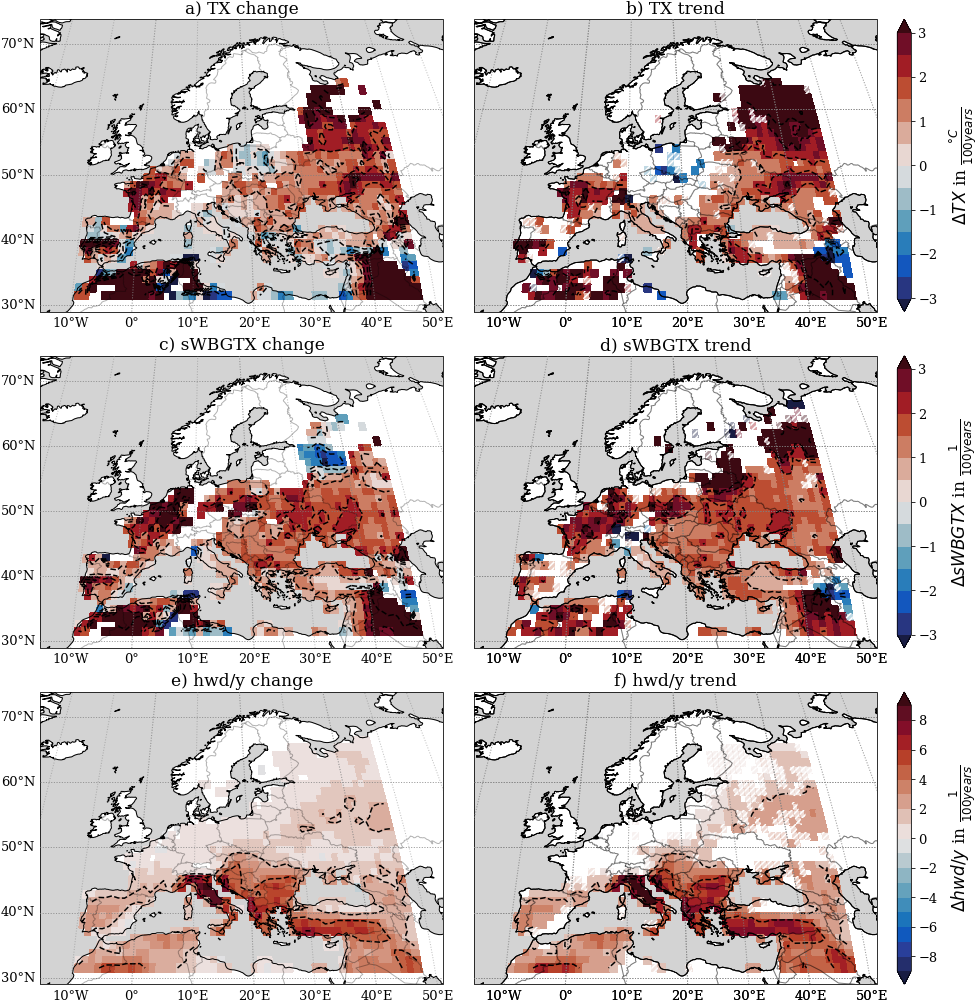

In [5]:
figure_title = 'Changes between 1900-1930 and 1990-2010\nTrends for period 1900-2010\nboth standardised to ' + r'$\frac{1}{100 years}$'
fig = plt.figure(figsize = (15,18))

gs = gridspec.GridSpec(nrows = 3, ncols = 2, wspace = 0.075, hspace = 0.1)
# fig.suptitle(figure_title, y=0.94)

cmap_trend = 'cmo.balance'

timeslice_first = slice("1900","1930")
timeslice_last = slice("1980","2010")
duration = 3
idx = 0


# ax0 = fig.add_subplot(gs_outer[:,2])
# ax0.axis('off')
# ax0.set_title('Change', fontsize = 15)

# ====== Plot ======

select_data = lambda variable, timeslice : data[variable].where(data.heatwave_mask_ydrunpctl_98_referenceperiod).sel(time = timeslice)
dim = 'time'
# ----- Temperature -----------
# Change
variable = "t2m"
plot_data = select_data(variable, timeslice_last).mean('time') - select_data(variable, timeslice_first).mean('time')
plot_data = plot_data.where(data.mask_land) *100/80

ax = fig.add_subplot(gs[0, 0], projection=projection)
pm, ct = plotfunc.area_plot(data= plot_data, ax = ax,
    levels = np.arange(0,3.1,0.5),
    cmap = cmap_trend,
    contour = True, contour_levels = np.arange(-5,5,1), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
    colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'))
ax.set_title('a) TX change')

# Trend
sel_data = data.t2m.where(data.mask_land).where(data.heatwave_mask_ydrunpctl_98_referenceperiod).chunk(dict(longitude = 8))
x = (sel_data[dim] - sel_data[dim][0]).astype(float)
linreg = trends.gufunc_linreg(x,sel_data, dim= dim)

ax0 = fig.add_subplot(gs[0,1],\
        projection=projection)


plot_data = linreg["slope"]* (x[-1]-x[0]) *100/110
pm0, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] <= 0.05),
                ax = ax0,
                levels = np.arange(0,3.1,0.5), cmap = cmap_trend,
                contour = True, contour_levels = np.arange(-5,5,1), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
                colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'),
                gridline_kwargs = dict(left_labels = left_labels))

pm, ct = plotfunc.area_plot(data= plot_data.where((linreg["p_value"] > 0.05) & (linreg["p_value"] <= 0.1)),
                ax = ax0, pcolormesh=False, pcolor= True,
                levels = np.arange(0,3.1,0.5), cmap = cmap_trend,
                colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'),
                gridline_kwargs = dict(left_labels = left_labels),
                pcolormesh_kwargs=dict(hatch = "////", alpha = 0.4))
ax0.set_title("b) TX trend")

# ----- sWBGT -----------
# Change
variable = "swbgt"
plot_data = select_data(variable, timeslice_last).mean('time') - select_data(variable, timeslice_first).mean('time')
plot_data = plot_data.where(data.mask_land) *100/80

ax = fig.add_subplot(gs[1, 0], projection=projection)
pm, ct = plotfunc.area_plot(data= plot_data, ax = ax,
    levels = np.arange(0,3.1,0.5),
    cmap = cmap_trend,
    contour = True, contour_levels = np.arange(-5,5,1), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
    colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'))
ax.set_title("c) sWBGTX change")

# Trend
sel_data = data.swbgt.where(data.mask_land).where(data.heatwave_mask_ydrunpctl_98_referenceperiod).chunk(dict(longitude = 8))
x = (sel_data[dim] - sel_data[dim][0]).astype(float)
linreg = trends.gufunc_linreg(x,sel_data, dim= dim)

ax1 = fig.add_subplot(gs[1,1],\
        projection=projection)


plot_data = linreg["slope"]* (x[-1]-x[0]) *100/110
pm1, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] <= 0.05),
                ax = ax1,
                levels = np.arange(0,3.1,0.5), cmap = cmap_trend,
                contour = True, contour_levels = np.arange(-5,5,1), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
                colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'),
                gridline_kwargs = dict(left_labels = left_labels))

pm, ct = plotfunc.area_plot(data= plot_data.where((linreg["p_value"] > 0.05) & (linreg["p_value"] <= 0.1)),
                ax = ax1, pcolormesh=False, pcolor= True,
                levels = np.arange(0,3.1,0.5), cmap = cmap_trend,
                colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'),
                gridline_kwargs = dict(left_labels = left_labels),
                pcolormesh_kwargs=dict(hatch = "////", alpha = 0.4))

ax1.set_title("d) sWBGTX trend")

# ----- heatwave days -----------
# Change
ax = fig.add_subplot(gs[2, 0], projection=projection)

variable = "heatwave_mask_ydrunpctl_98_referenceperiod"
plot_data = select_data(variable, timeslice_last).sum('time')/31 - select_data(variable, timeslice_first).sum('time')/31
plot_data = plot_data.where(data.mask_land).where(plot_data != 0) *100/80


pm, ct = plotfunc.area_plot(data= plot_data, ax = ax,
    levels = np.arange(0,12,1),
    cmap = cmap_trend,
    contour = True, contour_levels = np.arange(-10,10,3), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
    colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'))
ax.set_title("e) hwd/y change")

# Trend
ax2 = fig.add_subplot(gs[2,1],\
        projection=projection)

sel_data= data.heatwave_mask_ydrunpctl_98_referenceperiod.groupby('time.year').sum("time").where(data.mask_land).chunk(dict(longitude = 8))
x = (sel_data["year"] - sel_data["year"][0]).astype(float)
linreg = trends.gufunc_linreg(x,sel_data, dim= "year")
plot_data = linreg["slope"]* (x[-1]-x[0]) *100/110


plot_data = plot_data.where(plot_data != 0)
pm2, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] <= 0.05),
                ax = ax2,
                levels = np.arange(0,10,1), cmap = cmap_trend,
                colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'),
                contour = True, contour_levels = np.arange(-10,10,3), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
                gridline_kwargs = dict(left_labels = left_labels))

pm, ct = plotfunc.area_plot(data= plot_data.where((linreg["p_value"] > 0.05) & (linreg["p_value"] <= 0.1)),
                ax = ax2, pcolormesh=False, pcolor= True,
                levels = np.arange(0,10,1), cmap = cmap_trend,
                colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'),
                gridline_kwargs = dict(left_labels = left_labels),
                pcolormesh_kwargs=dict(hatch = "////", alpha = 0.4))
ax2.set_title("f) hwd/y trend")
# pm, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] >= 0.1),
#                 ax = ax2, pcolormesh=False, pcolor= True,
#                 levels = np.arange(0,10,1), cmap = cmap_trend,
#                 colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'),
#                 gridline_kwargs = dict(left_labels = left_labels),
#                 pcolormesh_kwargs=dict(hatch = "////", alpha = 0.4))

#         dived = False
def create_cbar_axes(ax):
    pos = ax.get_position()
    return fig.add_axes([pos.x0 + pos.width *1.05, pos.y0, pos.width *0.035, pos.height], frameon = False, xticks = [], yticks = [])
ax0 = create_cbar_axes(ax0)
ax1 = create_cbar_axes(ax1)
ax2 = create_cbar_axes(ax2)

# ax1 = fig.add_subplot(gs_outer[1,-1], frameon = False, xticks = [], yticks = [])
# ax2 = fig.add_subplot(gs_outer[2,-1], frameon = False, xticks = [], yticks = [])

plotfunc.add_cbar(fig,ax0,mapple_object=pm0, percentage = "120%", divide = False, extend = 'both', orientation = 'vertical', label = r'${\Delta} {TX}$ in $\frac{°C}{100 years}$')
plotfunc.add_cbar(fig,ax1,mapple_object=pm1, percentage = "120%", divide = False, extend = 'both', orientation = 'vertical', label = r'${\Delta} {sWBGTX}$ in $\frac{1}{100 years}$')
plotfunc.add_cbar(fig,ax2,mapple_object=pm2, percentage = "120%", divide = False, extend = 'both', orientation = 'vertical', label = r'${\Delta} {hwd/y}$ in $\frac{1}{100 years}$')

fig.savefig(areafolder + "area_changes_trends_ydrunpctl_98_referenceperiod")

/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


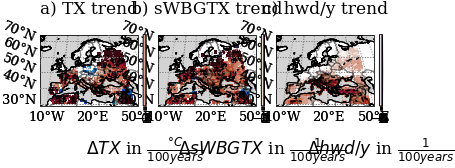

In [10]:
# trends only
fig = plt.figure(figsize = (6,24))

gs = gridspec.GridSpec(nrows = 12, ncols = 3, wspace = 0.2, hspace = 0.2)
# fig.suptitle(figure_title, y=0.94)

cmap_trend = 'cmo.balance'

timeslice_first = slice("1900","1930")
timeslice_last = slice("1980","2010")
duration = 3
idx = 0


# ax0 = fig.add_subplot(gs_outer[:,2])
# ax0.axis('off')
# ax0.set_title('Change', fontsize = 15)

# ====== Plot ======

select_data = lambda variable, timeslice : data[variable].where(data.heatwave_mask_ydrunpctl_98_referenceperiod).sel(time = timeslice)
dim = 'time'
# ----- Temperature -----------
# Trend
sel_data = data.t2m.where(data.mask_land).where(data.heatwave_mask_ydrunpctl_98_referenceperiod).chunk(dict(longitude = 8))
x = (sel_data[dim] - sel_data[dim][0]).astype(float)
linreg = trends.gufunc_linreg(x,sel_data, dim= dim)

ax0 = fig.add_subplot(gs[0:11,0],\
        projection=projection)


plot_data = linreg["slope"]* (x[-1]-x[0]) *100/110
pm0, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] <= 0.05),
                ax = ax0,
                levels = np.arange(0,3.1,0.5), cmap = cmap_trend,
                contour = True, contour_levels = np.arange(-5,5,1), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
                colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'))

pm, ct = plotfunc.area_plot(data= plot_data.where((linreg["p_value"] > 0.05) & (linreg["p_value"] <= 0.1)),
                ax = ax0, pcolormesh=False, pcolor= True,
                levels = np.arange(0,3.1,0.5), cmap = cmap_trend,
                colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'),
                pcolormesh_kwargs=dict(hatch = "////", alpha = 0.4))
ax0.set_title("a) TX trend")

# ----- sWBGT -----------
# Trend
sel_data = data.swbgt.where(data.mask_land).where(data.heatwave_mask_ydrunpctl_98_referenceperiod).chunk(dict(longitude = 8))
x = (sel_data[dim] - sel_data[dim][0]).astype(float)
linreg = trends.gufunc_linreg(x,sel_data, dim= dim)

ax1 = fig.add_subplot(gs[0:11,1],\
        projection=projection)


plot_data = linreg["slope"]* (x[-1]-x[0]) *100/110
pm1, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] <= 0.05),
                ax = ax1,
                levels = np.arange(0,3.1,0.5), cmap = cmap_trend,
                contour = True, contour_levels = np.arange(-5,5,1), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
                colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'))

pm, ct = plotfunc.area_plot(data= plot_data.where((linreg["p_value"] > 0.05) & (linreg["p_value"] <= 0.1)),
                ax = ax1, pcolormesh=False, pcolor= True,
                levels = np.arange(0,3.1,0.5), cmap = cmap_trend,
                colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'),
                pcolormesh_kwargs=dict(hatch = "////", alpha = 0.4))

ax1.set_title("b) sWBGTX trend")

# ----- heatwave days -----------
# Trend
ax2 = fig.add_subplot(gs[0:11,2],\
        projection=projection)

sel_data= data.heatwave_mask_ydrunpctl_98_referenceperiod.groupby('time.year').sum("time").where(data.mask_land).chunk(dict(longitude = 8))
x = (sel_data["year"] - sel_data["year"][0]).astype(float)
linreg = trends.gufunc_linreg(x,sel_data, dim= "year")
plot_data = linreg["slope"]* (x[-1]-x[0]) *100/110


plot_data = plot_data.where(plot_data != 0)
pm2, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] <= 0.05),
                ax = ax2,
                levels = np.arange(0,10,1), cmap = cmap_trend,
                colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'),
                contour = True, contour_levels = np.arange(-10,10,3), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5))

pm, ct = plotfunc.area_plot(data= plot_data.where((linreg["p_value"] > 0.05) & (linreg["p_value"] <= 0.1)),
                ax = ax2, pcolormesh=False, pcolor= True,
                levels = np.arange(0,10,1), cmap = cmap_trend,
                colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'),
                pcolormesh_kwargs=dict(hatch = "////", alpha = 0.4))
ax2.set_title("c) hwd/y trend")
# pm, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] >= 0.1),
#                 ax = ax2, pcolormesh=False, pcolor= True,
#                 levels = np.arange(0,10,1), cmap = cmap_trend,
#                 colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'),
#                 gridline_kwargs = dict(left_labels = left_labels),
#                 pcolormesh_kwargs=dict(hatch = "////", alpha = 0.4))

#         dived = False
def create_cbar_axes(ax):
    pos = ax.get_position()
    return fig.add_axes([pos.x0 + pos.width *1.05, pos.y0, pos.width *0.035, pos.height], frameon = False, xticks = [], yticks = [])
ax0 = create_cbar_axes(ax0)
ax1 = create_cbar_axes(ax1)
ax2 = create_cbar_axes(ax2)
def create_cbar_axes(ax):
    pos = ax.get_position()
    return fig.add_axes([pos.x0 , pos.y0 - pos.height *0.2, pos.width, pos.width  *0.045], frameon = False, xticks = [], yticks = [])
ax0 = create_cbar_axes(ax0)
ax1 = create_cbar_axes(ax1)
ax2 = create_cbar_axes(ax2)
# ax1 = fig.add_subplot(gs_outer[1,-1], frameon = False, xticks = [], yticks = [])
# ax2 = fig.add_subplot(gs_outer[2,-1], frameon = False, xticks = [], yticks = [])

plotfunc.add_cbar(fig,ax0,mapple_object=pm0, percentage = "120%", divide = False, extend = 'max', orientation = 'horizontal', label = 'mean TX in °C')
plotfunc.add_cbar(fig,ax1,mapple_object=pm1, percentage = "120%", divide = False, extend = 'both', orientation = 'horizontal', label = 'mean sWBGTX')
plotfunc.add_cbar(fig,ax2,mapple_object=pm2, percentage = "120%", divide = False, extend = 'max', orientation = 'horizontal', label = "heat wave days")

# ax1 = fig.add_subplot(gs_outer[1,-1], frameon = False, xticks = [], yticks = [])
# ax2 = fig.add_subplot(gs_outer[2,-1], frameon = False, xticks = [], yticks = [])

plotfunc.add_cbar(fig,ax0,mapple_object=pm0, percentage = "120%", divide = False, extend = 'both', orientation = 'horizontal', label = r'${\Delta} {TX}$ in $\frac{°C}{100 years}$')
plotfunc.add_cbar(fig,ax1,mapple_object=pm1, percentage = "120%", divide = False, extend = 'both', orientation = 'horizontal', label = r'${\Delta} {sWBGTX}$ in $\frac{1}{100 years}$')
plotfunc.add_cbar(fig,ax2,mapple_object=pm2, percentage = "120%", divide = False, extend = 'both', orientation = 'horizontal', label = r'${\Delta} {hwd/y}$ in $\frac{1}{100 years}$')

fig.savefig(areafolder + "area_trendsonly_hor_ydrunpctl_98_referenceperiod")

**Plot 98th percentile and change**

/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN sl

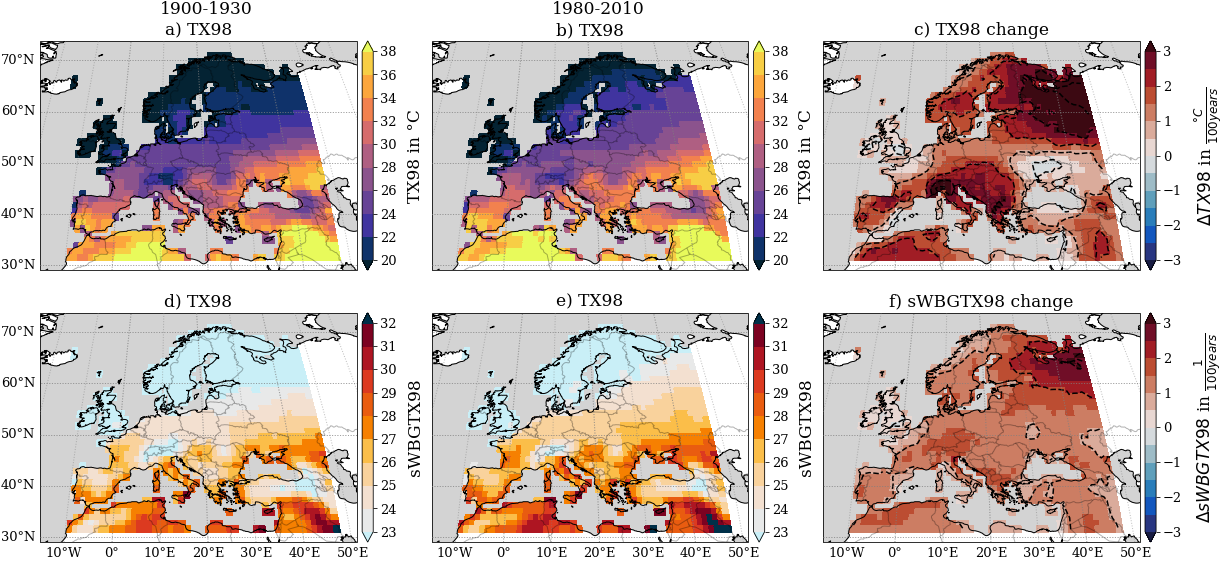

In [6]:
# figure_title = 'heatwave definition: \n {:.0f} days duration, {:.0f}°C daily max. temperature threshold, {:.0f}th percentile of temperature'.format(duration, threshold, quantile*100)
fig = plt.figure(figsize = (20,10))
# fig.suptitle(figure_title, y=0.94)

gs_outer = gridspec.GridSpec(2, 3, wspace = 0.175, hspace = 0.3)

timeslice_first = slice("1900","1930")
timeslice_last = slice("1980","2010")
duration = 3
idx = 0

ax0 = fig.add_subplot(gs_outer[:,0])
ax0.axis('off')
ax0.set_title('1900-1930')

ax0 = fig.add_subplot(gs_outer[:,1])
ax0.axis('off')
ax0.set_title('1980-2010')



idx = 0
idx_subfigure_label = 0
left_labels = True
for timeslice in [timeslice_first, timeslice_last]:
    
        total_years = (int(timeslice.start) - int(timeslice.stop))
        gs = gs_outer[:,idx].subgridspec(2, 1, hspace= 0., wspace= 0.)
# plot temperature
        ax = fig.add_subplot(gs[0, :], projection=projection)
        plot_data = (data.t2m.sel(time = timeslice).where(data.mask_land)).quantile(0.98, dim = 'time')
        pm, ct = plotfunc.area_plot(data= plot_data, ax = ax,             
                        levels = np.arange(20,40,2),             
                        cmap = 'cmo.thermal',
                        gridline_kwargs = dict(left_labels = left_labels, bottom_labels = False),
                        colorbar_kwargs = dict(label = "TX98 in °C"))
        ax.set_title(subfigure_label[idx_subfigure_label] + "TX98")
        idx_subfigure_label += 3
        
# plot sWBGT
        ax = fig.add_subplot(gs[1,:], projection=projection)
        plot_data = (data.swbgt.sel(time = timeslice).where(data.mask_land)).quantile(0.98, dim = 'time')
        pm, ct = plotfunc.area_plot(data= plot_data, ax = ax,             
                        levels = np.arange(23,33,1),             
                        cmap = plotfunc.thermal_low_extend,
                        gridline_kwargs = dict(left_labels = left_labels),
                        colorbar_kwargs = dict(label = "sWBGTX98"))
        ax.set_title(subfigure_label[idx_subfigure_label] + "TX98")
        idx_subfigure_label -= 2
        left_labels = False

        idx += 1

# # ================ plot TRENDS ================
# ax0 = fig.add_subplot(gs_outer[:,2])
# ax0.axis('off')
# ax0.set_title('Trend')

# gs = gs_outer[:,idx].subgridspec(2, 1, hspace= 0., wspace= 0.)
# dim = 'year'
# cmap_trend = 'cmo.balance'
# # TX
# sel_data = data.t2m.where(data.mask_land)
# sel_data = sel_data.groupby("time.year").quantile(0.98, dim = 'time').chunk(dict(longitude = 8))
# x = (sel_data[dim] - sel_data[dim][0]).astype(float)
# linreg = trends.gufunc_linreg(x,sel_data, dim= dim)

# ax0 = fig.add_subplot(gs[0,:],\
#         projection=projection)


# plot_data = linreg["slope"]* (x[-1]-x[0]) *100/110
# pm0, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] < 0.05),
#                 ax = ax0,
#                 levels = np.arange(0,3.1,0.5),
#                 cmap = 'cmo.balance',
#                 contour = True, contour_levels = np.arange(-5,5,1), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
#                 gridline_kwargs = dict(left_labels = left_labels, bottom_labels = False),
#                 colorbar_kwargs = dict(divergent = True, extend = 'both', label = r'${\Delta} {TX98}$ in $\frac{1}{100 years}$'))

# pm, ct = plotfunc.area_plot(data= plot_data.where((linreg["p_value"] >= 0.05) & (linreg["p_value"] < 0.1)),
#                 ax = ax0, pcolormesh=False, pcolor= True,
#                 levels = np.arange(0,3.1,0.5), cmap = cmap_trend,
#                 colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'),
#                 gridline_kwargs = dict(left_labels = left_labels, bottom_labels = False),
#                 pcolormesh_kwargs=dict(hatch = "////", alpha = 0.4))
# ax0.set_title("TX98 trend")


# # sWBGTX
# sel_data = data.swbgt.where(data.mask_land)
# sel_data = sel_data.groupby("time.year").quantile(0.98, dim = 'time').chunk(dict(longitude = 8))
# x = (sel_data[dim] - sel_data[dim][0]).astype(float)
# linreg = trends.gufunc_linreg(x,sel_data, dim= dim)

# ax0 = fig.add_subplot(gs[1,:],\
#         projection=projection)


# plot_data = linreg["slope"]* (x[-1]-x[0]) *100/110
# pm0, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] < 0.05),
#                 ax = ax0,
#                 levels = np.arange(0,3.1,0.5),
#                 cmap = 'cmo.balance',
#                 contour = True, contour_levels = np.arange(-5,5,1), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
#                 gridline_kwargs = dict(left_labels = left_labels),
#                 colorbar_kwargs = dict(divergent = True, extend = 'both', label = r'${\Delta} {sWBGTX98}$ in $\frac{1}{100 years}$'))

# pm, ct = plotfunc.area_plot(data= plot_data.where((linreg["p_value"] >= 0.05) & (linreg["p_value"] < 0.1)),
#                 ax = ax0, pcolormesh=False, pcolor= True,
#                 levels = np.arange(0,3.1,0.5), cmap = cmap_trend,
#                 colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'),
#                 gridline_kwargs = dict(left_labels = left_labels),
#                 pcolormesh_kwargs=dict(hatch = "////", alpha = 0.4))

# ax0.set_title("sWBGTX98 trend")

# fig.savefig(areafolder + "30year_period_98thpercentile_ydrunpctl_98_referenceperiod_trends")

# ================ plot difference ================

# ax0 = fig.add_subplot(gs_outer[:,2])
# ax0.axis('off')
# ax0.set_title('Change')

select_data = lambda variable, timeslice : data[variable].sel(time = timeslice).where(data.mask_land)

gs = gs_outer[:,idx].subgridspec(2, 1, hspace= 0., wspace= 0.)
# plot temperature
variable = "t2m"
plot_data = (select_data(variable, timeslice_last)).quantile(0.98, dim = 'time') - (select_data(variable, timeslice_first)).quantile(0.98, dim = 'time')
plot_data = plot_data * (100/80)

ax = fig.add_subplot(gs[0, :], projection=projection)
pm, ct = plotfunc.area_plot(data= plot_data, ax = ax,
    levels = np.arange(0,3.1,0.5),
    cmap = 'cmo.balance',
    contour = True, contour_levels = np.arange(-5,5,1), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
    gridline_kwargs = dict(left_labels = left_labels, bottom_labels = False),
    colorbar_kwargs = dict(divergent = True, extend = 'both', label = r'${\Delta} {TX98}$ in $\frac{°C}{100 years}$'))
ax.set_title(subfigure_label[idx_subfigure_label] + "TX98 change")
idx_subfigure_label += 3
# plot sWBGT
variable = "swbgt"
plot_data = select_data(variable, timeslice_last).quantile(0.98, dim = 'time') - select_data(variable, timeslice_first).quantile(0.98, dim = 'time')
plot_data = plot_data * (100/80)

ax = fig.add_subplot(gs[1, :], projection=projection)
pm, ct = plotfunc.area_plot(data= plot_data, ax = ax,
    levels = np.arange(0,3.1,0.5),
    cmap = 'cmo.balance',
    contour = True, contour_levels = np.arange(-5,5,1), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
    gridline_kwargs = dict(left_labels = left_labels),
    colorbar_kwargs = dict(divergent = True, extend = 'both', label = r'${\Delta} {sWBGTX98}$ in $\frac{1}{100 years}$'))
ax.set_title(subfigure_label[idx_subfigure_label] + "sWBGTX98 change")

fig.savefig(areafolder + "30year_period_98thpercentile_ydrunpctl_98_referenceperiod")

**Plot mean and change**

/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


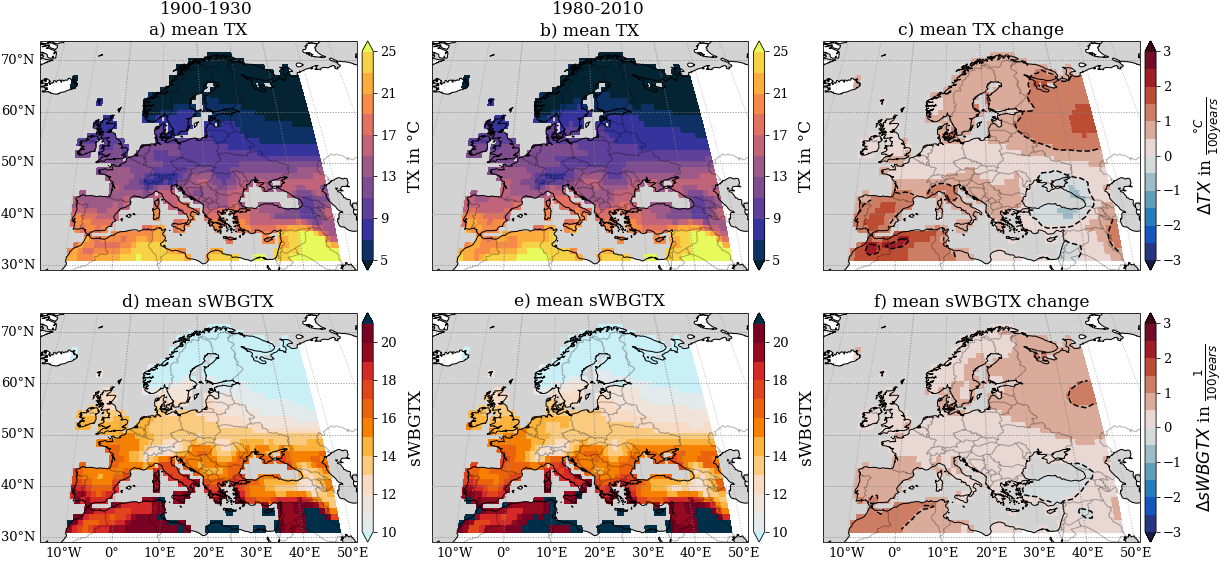

In [8]:
# figure_title = 'heatwave definition: \n {:.0f} days duration, {:.0f}°C daily max. temperature threshold, {:.0f}th percentile of temperature'.format(duration, threshold, quantile*100)
fig = plt.figure(figsize = (20,10))
# fig.suptitle(figure_title, y=0.94)

gs_outer = gridspec.GridSpec(2, 3, wspace = 0.175, hspace = 0.3)

timeslice_first = slice("1900","1930")
timeslice_last = slice("1980","2010")
duration = 3
idx = 0

ax0 = fig.add_subplot(gs_outer[:,0])
ax0.axis('off')
ax0.set_title('1900-1930')

ax0 = fig.add_subplot(gs_outer[:,1])
ax0.axis('off')
ax0.set_title('1980-2010')

# ax0 = fig.add_subplot(gs_outer[:,2])
# ax0.axis('off')
# ax0.set_title('Change')

idx = 0
idx_subfigure_label = 0
left_labels = True
for timeslice in [timeslice_first, timeslice_last]:
    
        total_years = (int(timeslice.start) - int(timeslice.stop))
        gs = gs_outer[:,idx].subgridspec(2, 1, hspace= 0., wspace= 0.)
# plot temperature
        ax = fig.add_subplot(gs[0, :], projection=projection)
        plot_data = (data.t2m.sel(time = timeslice).where(data.mask_land)).mean('time')
        pm, ct = plotfunc.area_plot(data= plot_data, ax = ax,             
                        levels = np.arange(5,26,2),             
                        cmap = 'cmo.thermal',
                        gridline_kwargs = dict(left_labels = left_labels, bottom_labels = False),
                        colorbar_kwargs = dict(label = "TX in °C"))
        ax.set_title(subfigure_label[idx_subfigure_label] + "mean TX")
        idx_subfigure_label += 3
        
# plot sWBGT
        ax = fig.add_subplot(gs[1,:], projection=projection)
        plot_data = (data.swbgt.sel(time = timeslice).where(data.mask_land)).mean('time')
        pm, ct = plotfunc.area_plot(data= plot_data, ax = ax,             
                        levels = np.arange(10,22,1),             
                        cmap = plotfunc.thermal_low_extend,
                            gridline_kwargs = dict(left_labels = left_labels),
                        colorbar_kwargs = dict(label = "sWBGTX"))
        ax.set_title(subfigure_label[idx_subfigure_label] + "mean sWBGTX")
        idx_subfigure_label -= 2
        
        
        left_labels = False
        idx += 1


# # ================ plot trends ================
# gs = gs_outer[:,idx].subgridspec(2, 1, hspace= 0., wspace= 0.)
# dim = 'time'
# cmap_trend = 'cmo.balance'
# # TX
# sel_data = data.t2m.where(data.mask_land).chunk(dict(longitude = 8))
# x = (sel_data[dim] - sel_data[dim][0]).astype(float)
# linreg = trends.gufunc_linreg(x,sel_data, dim= dim)

# ax0 = fig.add_subplot(gs[0,:],\
#         projection=projection)


# plot_data = linreg["slope"]* (x[-1]-x[0]) *100/110
# pm0, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] < 0.05),
#                 ax = ax0,
#                 levels = np.arange(0,3.1,0.5),
#                 cmap = 'cmo.balance',
#                 contour = True, contour_levels = np.arange(-5,5,1), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
#                 gridline_kwargs = dict(left_labels = left_labels, bottom_labels = False),
#                 colorbar_kwargs = dict(divergent = True, extend = 'both', label = r'${\Delta} {TX}$ in $\frac{1}{100 years}$'))

# pm, ct = plotfunc.area_plot(data= plot_data.where((linreg["p_value"] >= 0.05) & (linreg["p_value"] < 0.1)),
#                 ax = ax0, pcolormesh=False, pcolor= True,
#                 levels = np.arange(0,3.1,0.5), cmap = cmap_trend,
#                 colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'),
#                 gridline_kwargs = dict(left_labels = left_labels, bottom_labels = False),
#                 pcolormesh_kwargs=dict(hatch = "////", alpha = 0.4))

# ax0.set_title("TX trend")

# # sWBGTX
# sel_data = data.swbgt.where(data.mask_land).chunk(dict(longitude = 8))
# x = (sel_data[dim] - sel_data[dim][0]).astype(float)
# linreg = trends.gufunc_linreg(x,sel_data, dim= dim)

# ax0 = fig.add_subplot(gs[1,:],\
#         projection=projection)


# plot_data = linreg["slope"]* (x[-1]-x[0]) *100/110
# pm0, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] < 0.05),
#                 ax = ax0,
#                 levels = np.arange(0,3.1,0.5),
#                 cmap = 'cmo.balance',
#                 contour = True, contour_levels = np.arange(-5,5,1), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
#                 gridline_kwargs = dict(left_labels = left_labels),
#                 colorbar_kwargs = dict(divergent = True, extend = 'both', label = r'${\Delta} {sWBGTX}$ in $\frac{1}{100 years}$'))

# pm, ct = plotfunc.area_plot(data= plot_data.where((linreg["p_value"] >= 0.05) & (linreg["p_value"] < 0.1)),
#                 ax = ax0, pcolormesh=False, pcolor= True,
#                 levels = np.arange(0,3.1,0.5), cmap = cmap_trend,
#                 colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'),
#                 gridline_kwargs = dict(left_labels = left_labels),
#                 pcolormesh_kwargs=dict(hatch = "////", alpha = 0.4))
# ax0.set_title("sWBGTX trend")


# fig.savefig(areafolder + "30year_period_mean_ydrunpctl_98_referenceperiod_trends")

# ================ plot difference ================

select_data = lambda variable, timeslice : data[variable].sel(time = timeslice).where(data.mask_land)

gs = gs_outer[:,idx].subgridspec(2, 1, hspace= 0., wspace= 0.)
# plot temperature
variable = "t2m"
plot_data = (select_data(variable, timeslice_last)).mean('time') - (select_data(variable, timeslice_first)).mean('time')
plot_data = plot_data * (100/80)

ax = fig.add_subplot(gs[0, :], projection=projection)
pm, ct = plotfunc.area_plot(data= plot_data, ax = ax,
    levels = np.arange(0,3.1,0.5),
    contour = True, contour_levels = np.arange(-5,5,1), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
    cmap = 'cmo.balance',
    gridline_kwargs = dict(left_labels = left_labels, bottom_labels = False),
    colorbar_kwargs = dict(divergent = True, extend = 'both',label = r'${\Delta} {TX}$ in $\frac{°C}{100 years}$'))
ax.set_title(subfigure_label[idx_subfigure_label] + "mean TX change")
idx_subfigure_label += 3
# plot sWBGT
variable = "swbgt"
plot_data = select_data(variable, timeslice_last).mean('time') - select_data(variable, timeslice_first).mean('time')
plot_data = plot_data * (100/80)

ax = fig.add_subplot(gs[1, :], projection=projection)
pm, ct = plotfunc.area_plot(data= plot_data, ax = ax,
    levels = np.arange(0,3.1,0.5),
    contour = True, contour_levels = np.arange(-5,5,1), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
    cmap = 'cmo.balance',
    gridline_kwargs = dict(left_labels = left_labels),
    colorbar_kwargs = dict(divergent = True, extend = 'both', label = r'${\Delta} {sWBGTX}$ in $\frac{1}{100 years}$'))
ax.set_title(subfigure_label[idx_subfigure_label] + "mean sWBGTX change")

fig.savefig(areafolder + "30year_period_mean_ydrunpctl_98_referenceperiod")

**REST**